In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv('data/data_all.csv').iloc[:,1:]

In [3]:
data.head()

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Date,DATE_HOUR,CRASH_DATE,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH
0,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:55:00,CLEAR,DAYLIGHT,DRY,1.0,0.0,15.0,1.0,8.0
1,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:52:00,CLEAR,DAYLIGHT,DRY,2.0,0.0,15.0,1.0,8.0
2,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:45:00,CLEAR,DAYLIGHT,DRY,0.0,0.0,15.0,1.0,8.0
3,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:30:00,CLEAR,DAYLIGHT,DRY,0.0,0.0,15.0,1.0,8.0
4,94,63,36,20,26,29.4,2018-08-05,2018-08-05 15,2018-08-05 15:25:00,CLEAR,DAYLIGHT,DRY,3.0,0.0,15.0,1.0,8.0


Aggregation based on each hour

In [4]:
data_agg = data.groupby('DATE_HOUR').agg({'Temperature': 'mean', 'Dew Point': 'mean', 'Humidity': 'mean', 'Wind Speed': 'mean', 'Pressure': 'mean', 'Date': 'count'}).reset_index().rename(columns = {'Date': 'Crashes'})

In [5]:
data_agg.head()

,DATE_HOUR,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Crashes
0,2018-08-05 15,94.0,63.0,36.0,20.0,29.4,11
1,2018-08-05 16,93.0,64.0,38.0,18.0,29.3,14
2,2018-08-05 17,93.0,63.0,37.0,17.0,29.3,14
3,2018-08-05 18,90.0,67.0,46.0,14.0,29.4,13
4,2018-08-05 19,88.0,68.0,51.0,9.0,29.4,11


Categorical variables. We cannot use them in groupby since there are categorical, but the one way to keep categorical variable is to save separetely unique values of categorical variables for each unique 'DATE_HOUR' feature. Then we can merge agg data frame with categoracal variables data frame based on 'DATE_HOUR' feature since there are unique in both data frames. 

In [6]:
cat_variab = data.drop_duplicates(subset='DATE_HOUR')[['DATE_HOUR', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK']]

Change format for 'CRASH_HOUR' and 'CRASH_DAY_OF_WEEK' from 'float' to 'category'

In [7]:
cat_variab['CRASH_HOUR'] = cat_variab['CRASH_HOUR'].astype('int').astype('category')
cat_variab['CRASH_DAY_OF_WEEK'] = cat_variab['CRASH_DAY_OF_WEEK'].astype('int').astype('category')

In [8]:
data_merged = pd.merge(data_agg, cat_variab, on = 'DATE_HOUR')

In [9]:
data_merged.head()

,DATE_HOUR,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Crashes,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,CRASH_HOUR,CRASH_DAY_OF_WEEK
0,2018-08-05 15,94.0,63.0,36.0,20.0,29.4,11,CLEAR,DAYLIGHT,DRY,15,1
1,2018-08-05 16,93.0,64.0,38.0,18.0,29.3,14,CLEAR,DAYLIGHT,DRY,16,1
2,2018-08-05 17,93.0,63.0,37.0,17.0,29.3,14,CLEAR,DAYLIGHT,DRY,17,1
3,2018-08-05 18,90.0,67.0,46.0,14.0,29.4,13,CLEAR,DAYLIGHT,DRY,18,1
4,2018-08-05 19,88.0,68.0,51.0,9.0,29.4,11,CLEAR,DUSK,DRY,19,1


Target Variable

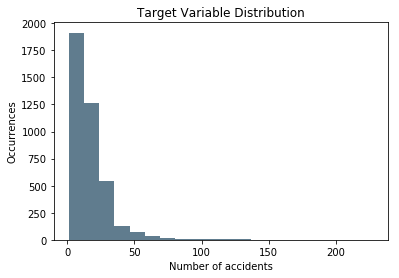

In [10]:
plt.hist(data_merged['Crashes'].values, 20, density=False, align='mid', color='#607c8e')
plt.title('Target Variable Distribution')
plt.xlabel('Number of accidents')
plt.ylabel('Occurrences')
plt.savefig('pics/target.png')

Log Transformation can help handle outliers!

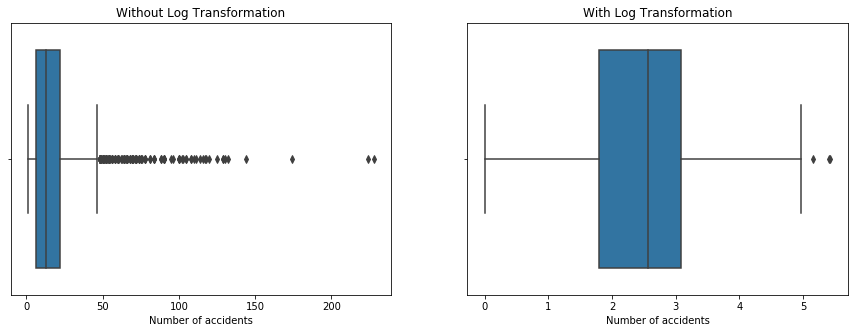

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxplot(data_merged['Crashes'])
plt.xlabel('Number of accidents')
plt.title('Without Log Transformation')
plt.subplot(1, 2, 2)
sns.boxplot(np.log(data_merged['Crashes']))
plt.xlabel('Number of accidents')
plt.title('With Log Transformation')
plt.savefig('pics/target_boxplot.png')

In [12]:
data_merged['Crashes'] = np.log(data_merged['Crashes'])

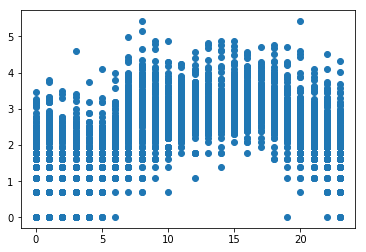

In [13]:
plt.scatter(data_merged['CRASH_HOUR'], data_merged['Crashes'])

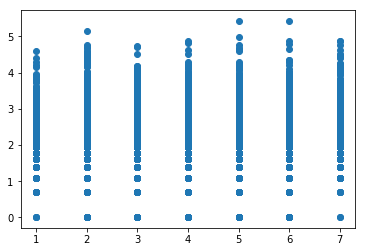

In [14]:
plt.scatter(data_merged['CRASH_DAY_OF_WEEK'], data_merged['Crashes'])

Text(0, 0.5, 'Occurrences')

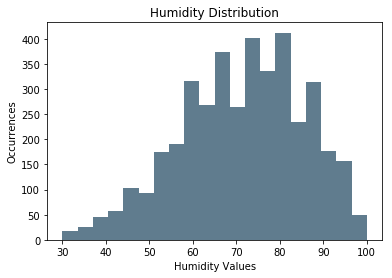

In [15]:
plt.hist(data_merged['Humidity'].values, 20, density=False, align='mid', color='#607c8e');
plt.title('Humidity Distribution')
plt.xlabel('Humidity Values')
plt.ylabel('Occurrences')

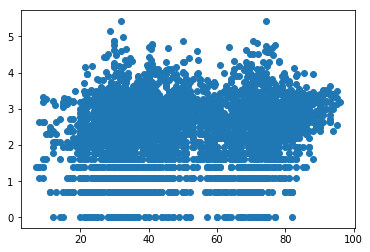

In [16]:
plt.scatter(data_merged['Temperature'], data_merged['Crashes'])

Text(0.5, 1.0, 'Wind Speed Distribution with transformation')

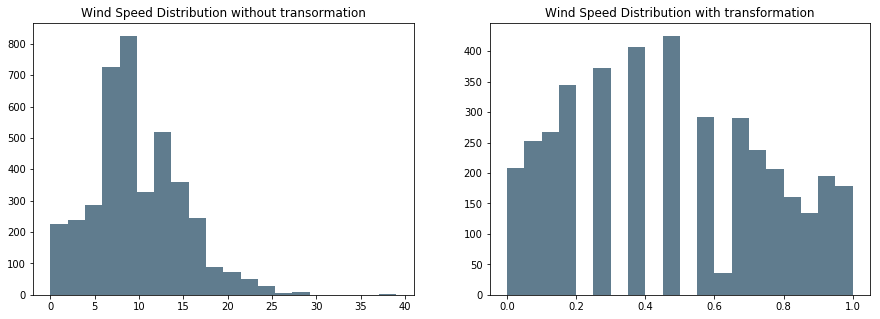

In [17]:
size = len(data_merged['Wind Speed'])-1
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.hist(data_merged['Wind Speed'], 20, density=False, align='mid', color='#607c8e')
plt.title('Wind Speed Distribution without transormation')
plt.subplot(1, 2, 2)
plt.hist(data_merged['Wind Speed'].rank(method='min').apply(lambda x: (x-1)/size), 20, density=False, align='mid', color='#607c8e')
plt.title('Wind Speed Distribution with transformation')


In [18]:
data_merged['Wind Speed'] = data_merged['Wind Speed'].rank(method='min').apply(lambda x: (x-1)/size)

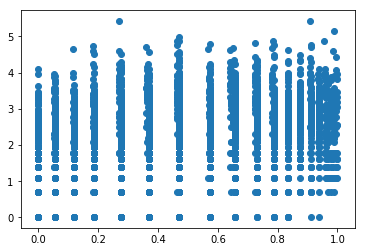

In [19]:
plt.scatter(data_merged['Wind Speed'], data_merged['Crashes'])

There is a multicollinearity in our data between Temperature and Dew Point. So, we are going to use only one feature - Temperature 

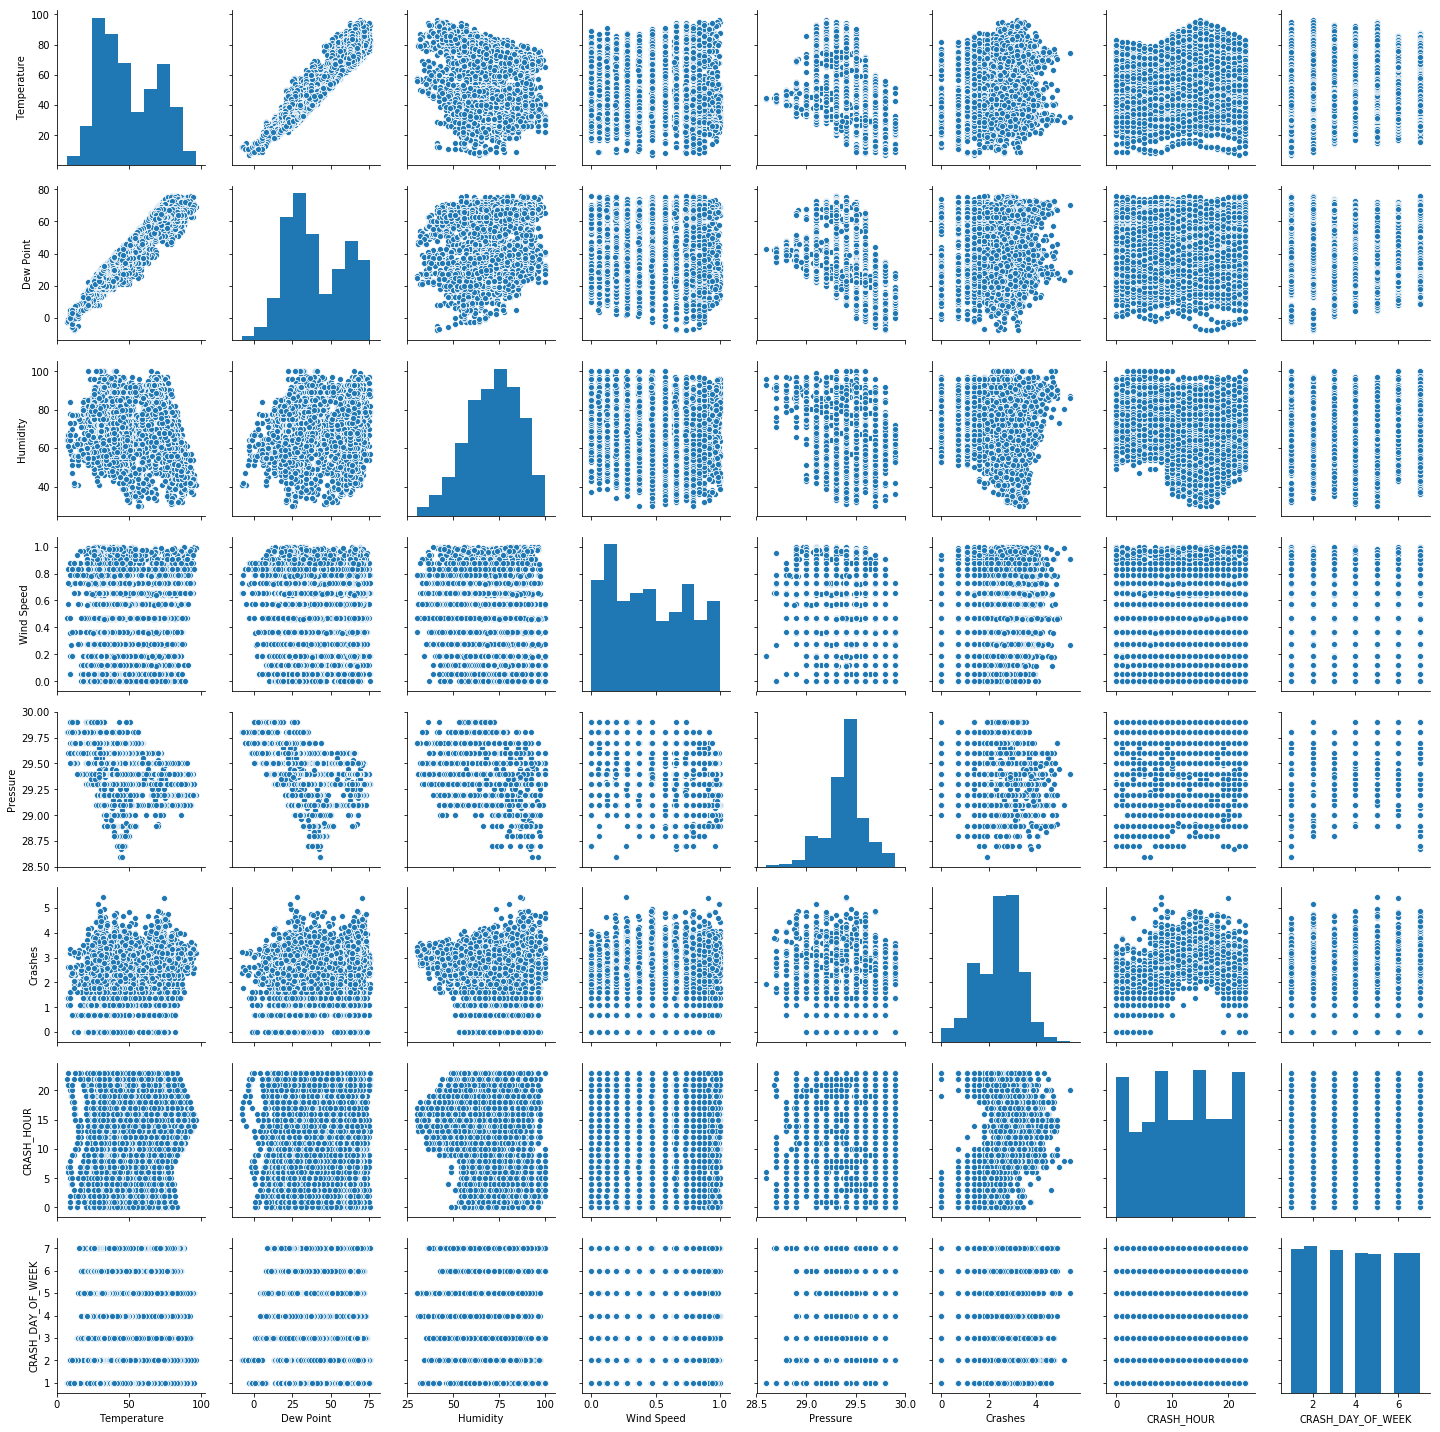

In [20]:
sns.pairplot(data_merged);

In [21]:
data_merged.head()

,DATE_HOUR,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Crashes,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,CRASH_HOUR,CRASH_DAY_OF_WEEK
0,2018-08-05 15,94.0,63.0,36.0,0.960080,29.4,2.397895,CLEAR,DAYLIGHT,DRY,15,1
1,2018-08-05 16,93.0,64.0,38.0,0.936627,29.3,2.639057,CLEAR,DAYLIGHT,DRY,16,1
2,2018-08-05 17,93.0,63.0,37.0,0.910928,29.3,2.639057,CLEAR,DAYLIGHT,DRY,17,1
3,2018-08-05 18,90.0,67.0,46.0,0.786178,29.4,2.564949,CLEAR,DAYLIGHT,DRY,18,1
4,2018-08-05 19,88.0,68.0,51.0,0.471557,29.4,2.397895,CLEAR,DUSK,DRY,19,1


In [22]:
data_merged = data_merged.drop('Dew Point', axis = 1)

In [23]:
X = data_merged.drop('Crashes', axis = 1)

Train/test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, data_merged['Crashes'], test_size=0.2,random_state=5, shuffle = False)

Scaling

Scaling is very important for linear regression, by scaling we can be sure that we don't bias coefficients of model due to maginitudes of different features.

In [25]:
std = StandardScaler()

In [26]:
cat_feat = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK']
num_feat = ['Temperature', 'Humidity', 'Wind Speed', 'Pressure']

In [27]:
std.fit(X_train[num_feat].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
X_train_sc_num = pd.DataFrame(std.transform(X_train[num_feat].values), columns = num_feat)
X_test_sc_num = pd.DataFrame(std.transform(X_test[num_feat].values), columns = num_feat)

In [29]:
X_train_sc_cat = X_train[cat_feat].reset_index(drop = True)
X_test_sc_cat = X_test[cat_feat].reset_index(drop = True)

In [30]:
X_train_sc = pd.concat([X_train_sc_num, X_train_sc_cat], axis=1, join_axes=[X_train_sc_cat.index])
X_test_sc = pd.concat([X_test_sc_num, X_test_sc_cat], axis=1, join_axes=[X_test_sc_cat.index])

In [31]:
X_train_sc = pd.get_dummies(X_train_sc)
X_test_sc = pd.get_dummies(X_test_sc)

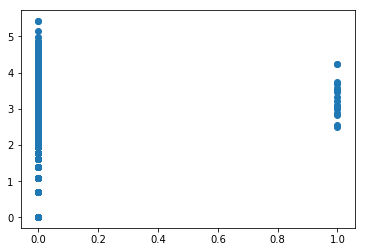

In [32]:
plt.scatter(X_train_sc['CRASH_HOUR_11']*X_train_sc['ROADWAY_SURFACE_COND_WET'], y_train)

The reason why there are so many variables mainly lies in the nature of our features - most of them are categorical. Using categorical variables in a model makes us to convert them with the one-hot encoding technique and treat each possible value as the binary variable. Usually high dimentinality causes the overfitting - so exactly this reason we will use regularization parameter and compare results with the regular regression later.

### Modeling

### Linear Regression

In [33]:
model = sm.OLS(np.array(y_train), sm.add_constant(np.array(X_train_sc)))
results = model.fit()
results.summary();

##### Cross Validation Results for Linear Model without Feature Selection (not stable)

In [34]:
lm = LinearRegression()
lm.fit(X_train_sc, y_train)
scores_lm = cross_val_score(lm, X_train_sc, y_train, # estimator, features, target
                cv=10, # number of folds 
                scoring='r2') # scoring metric
print('Scores on 10 folds: \n{}'.format(scores_lm))
print('---------------------------------------------------------------------------------------------')
print('Mean: {}, \nVariance: {}'.format(np.mean(scores_lm), np.std(scores_lm)))

Scores on 10 folds: 
[ 6.15119142e-01  5.90709977e-01  5.54921644e-01  6.01126064e-01
 -5.13175236e+20  6.56474238e-01  5.88794643e-01  5.69336546e-01
  3.77540769e-01  5.51266063e-01]
---------------------------------------------------------------------------------------------
Mean: -5.1317523586713756e+19, 
Variance: 1.5395257076014124e+20


Text(0, 0.5, 'R^2')

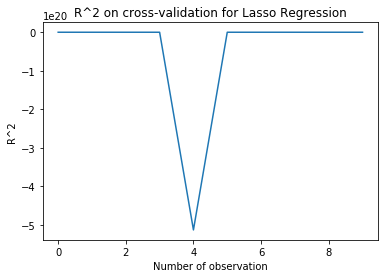

In [35]:
plt.plot(scores_lm)
plt.title('R^2 on cross-validation for Lasso Regression')
plt.xlabel('Number of observation')
plt.ylabel('R^2')

In [36]:
#Mean Square Error (MAE)
def mse(y_true, y_pred):
    return np.mean((y_pred - y_true)**2) 

In [37]:
mse(y_test.values, lm.predict(X_test_sc))

4.141179186175254e+20

##### Cross Validation Results for Lasso Regularization

In [38]:
alphavec = np.linspace(0.0000001,3,200)

In [39]:
lasso_model = LassoCV(alphas = alphavec, cv=10) # Tuning Regularization Strength via Validation
lasso_model.fit(X_train_sc, y_train)

LassoCV(alphas=array([1.00000e-07, 1.50755e-02, ..., 2.98492e+00, 3.00000e+00]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [40]:
lasso_model.score(X_train_sc, y_train)

0.5887367321877374

Text(0, 0.5, 'R^2')

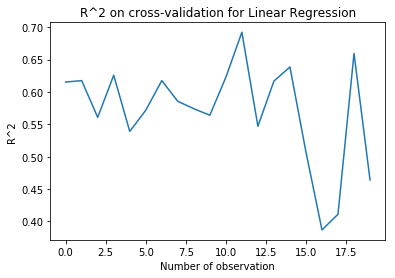

In [41]:
alphavec = np.linspace(0.0000001,3,200)
lasso_model = LassoCV(alphas = alphavec, cv=10) # Tuning Regularization Strength via Validation
lasso_model.fit(X_train_sc, y_train)
lasso_model.score(X_train_sc, y_train)
scores_lasso = cross_val_score(lasso_model, X_train_sc, y_train, # estimator, features, target
                cv=20, # number of folds 
                scoring='r2') # scoring metric
np.mean(scores_lasso) #mean
np.std(scores_lasso)#variance
plt.plot(scores_lasso)
plt.title('R^2 on cross-validation for Linear Regression')
plt.xlabel('Number of observation')
plt.ylabel('R^2')

Notice that among all scores there are no huge drops here as in the previous case, where we had no regularization parameter. Lasso regularizations help to get rid of noise and generalize on the test data set.

In [42]:
test_score_lasso = mse(y_test.values, lasso_model.predict(X_test_sc))
test_score_lasso

0.487629370653211

Amazing! It's now more obvious how much the regularization helps to keep our model accurate and generalize well on test daya set

Investigating the feature importance

In [43]:
feature_importance = {}

In [44]:
feature_importance = dict(zip(X_train_sc.columns, lasso_model.coef_))

In [45]:
sorted_d = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse = True)

In [46]:
sorted_d[0:22]

[('CRASH_HOUR_4', -1.5330530928789114),
 ('CRASH_HOUR_3', -1.356493964947647),
 ('CRASH_HOUR_2', -1.349533866140599),
 ('CRASH_HOUR_1', -1.192745086887749),
 ('CRASH_HOUR_5', -1.1206298843674927),
 ('CRASH_HOUR_0', -1.1141859688283948),
 ('ROADWAY_SURFACE_COND_SAND, MUD, DIRT', 0.8840810406165195),
 ('CRASH_HOUR_23', -0.7685141038072648),
 ('CRASH_HOUR_6', -0.6681925153354056),
 ('CRASH_HOUR_17', 0.6553014707642426),
 ('CRASH_HOUR_15', 0.5970604570504713),
 ('CRASH_HOUR_16', 0.5758235770919989),
 ('CRASH_HOUR_22', -0.49517200473352285),
 ('WEATHER_CONDITION_FOG/SMOKE/HAZE', 0.41954185583221015),
 ('CRASH_HOUR_14', 0.41635901344188553),
 ('WEATHER_CONDITION_OTHER', -0.4152070443450652),
 ('CRASH_HOUR_18', 0.40812031877675176),
 ('CRASH_HOUR_13', 0.3903464190055313),
 ('CRASH_HOUR_12', 0.36867184686918586),
 ('CRASH_HOUR_21', -0.3223154597384699),
 ('CRASH_HOUR_11', 0.2558382559210646),
 ('ROADWAY_SURFACE_COND_UNKNOWN', -0.21826235169093108)]

Let's try another technoques of feature selection

### Feature Selection

#### Statistical approaches

1. Variance threshold selector   
Idea: Feature selector that removes all low-variance features

In [47]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [48]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [49]:
variance_threshold_selector(X_train_sc, threshold=0.5).head()

,Temperature,Humidity,Wind Speed,Pressure
0,2.036235,-2.361353,1.758529,0.059107
1,1.984520,-2.222250,1.677752,-0.465978
2,1.984520,-2.291802,1.589240,-0.465978
3,1.829378,-1.665834,1.159575,0.059107
4,1.725949,-1.318074,0.075958,0.059107


In [50]:
vts_col = variance_threshold_selector(X_train_sc, threshold=0.5).head().columns

In [51]:
x_data_varth = VarianceThreshold(.8).fit_transform(X_train_sc)


In [52]:
cross_val_score(lm, x_data_varth, y_train, 
                scoring='r2', cv=10)

array([ 0.17833864,  0.10168026,  0.0924514 ,  0.06586996, -0.05072766,
        0.13606787,  0.05664745, -0.02857722,  0.01078158, -0.06344056])

In [53]:
lm_vts = LinearRegression().fit( x_data_varth, y_train)

In [54]:
test_score_vts = mse(y_test.values, lm_vts.predict(X_test_sc[vts_col]))
test_score_vts

0.8115618933597386

We can witness drops in the cross validation scores. This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.

2. SelectKBest  
The SelectKBest class just scores the features using a function (in this case f_classif but could be others) and then "removes all but the k highest scoring features"

In [55]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train_sc, y_train)
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
kbest_col = X_train_sc.columns[cols]

In [56]:
x_data_kbest = SelectKBest(f_classif, k=10).fit_transform(X_train_sc, y_train)

In [57]:
cross_val_score(lm, x_data_kbest, y_train, y_train, 
                scoring='r2', cv=10)

array([0.41920627, 0.32563312, 0.39436955, 0.41080591, 0.35354101,
       0.39437908, 0.32598986, 0.34964055, 0.16330153, 0.30134114])

In [58]:
lm_kbest = LinearRegression().fit( x_data_kbest, y_train)

In [59]:
test_score_kbest = mse(y_test.values, lm_kbest.predict(X_test_sc[kbest_col]))
test_score_kbest 

0.6680919795987482

#### Random Forest for Feature Selection

In [60]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


In [61]:
rf = RandomForestRegressor(n_estimators=7, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), lm)
pipe.fit(X_train_sc, y_train)
cross_val_score(pipe, X_train_sc, y_train, 
                scoring='r2', cv=10)

array([0.42288725, 0.38882701, 0.46823643, 0.44914927, 0.37497441,
       0.47246415, 0.40166229, 0.36895924, 0.30636777, 0.33365344])

In [62]:
X_train_sc.shape

(3207, 55)

In [63]:
y_train.shape

(3207,)

In [64]:
test_score_pipe = mse(y_test.values, pipe.predict(X_test_sc))
test_score_pipe

0.6782459700618935

Lasso regularizations wins among all considered feature selection technoques.

In [65]:
objects = ('Lasso', 'Variance threshold', 'Kbest', 'Random Forest')
y_pos = np.arange(len(objects))*2

Text(0.5, 1.0, 'Perfomance of different feature selection approaches')

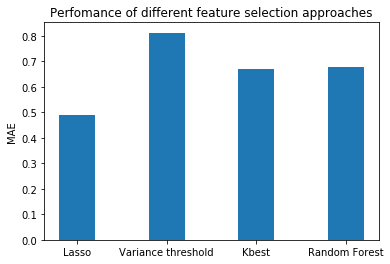

In [66]:
plt.bar(y_pos, [test_score_lasso, test_score_vts, test_score_kbest, test_score_pipe])
plt.xticks(y_pos, objects)
plt.ylabel('MAE')
plt.title('Perfomance of different feature selection approaches')